In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [2]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def state_setup(state_length, letter_vecs, N, D, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            #mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            #states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv

    return states, coef_hists

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, atol, rtol, max_steps=500):
    th_vec = bound_vec.copy()
    all_converged = np.zeros(state_length-2)
    all_diffs = np.zeros((state_length-2, D))
    for i in range(max_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            
            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                atol=atol, rtol=rtol)

                all_diffs[j-1] = coef_hists[j-1][i,:] - coef_hists[j-1][i-1, :]
                
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
        
        if np.all(all_converged):
            break

        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv
    #print ('diffs', all_diffs)
    return states, coef_hists, all_converged, i

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        step, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        alphis.append(alphi)
        pred += alph[alphi]
        
    return pred, alphis
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
        #print ('alphi', alphi)
    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [3]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 5000
D = len(alph)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'

In [4]:
pres_categories, past_categories = RM_utils.exemplars()
verbs = []
testverbs = []
cutoff = 2

# let's start with only 1 category
# for key in pres_categories.keys():
for key in range(1):
    for i in range(cutoff):
        verbs.append([past_categories[key][i], pres_categories[key][i]])
    testverbs.append([
        past_categories[key][cutoff],
        pres_categories[key][cutoff]
    ])

verbs.append(['jumped', 'jump'])
verbs.append(['walked', 'walk'])
testverbs.append(['pumped', 'pump'])

print verbs
print testverbs

[['beaten', 'beat'], ['fitted', 'fit'], ['jumped', 'jump'], ['walked', 'walk']]
[['set', 'set'], ['pumped', 'pump']]


In [5]:
diff, pres1, pres2, past1, past2 = RM_utils.genX(verbs, N, dic1, dic2, alph)
testdiff, testpres1, testpres2, testpast1, testpast2 = RM_utils.genX(testverbs, N, dic1, dic2, alph)

bound_vec = np.zeros(N)
bound_vec = RM_utils.train_diff_bulk(bound_vec, past2, pres1, pres2, N)

(array([ 1.,  1.,  1.,  1.,  1.,  1.]), 86)
('alphis', [1, 4, 0, 19, 6, 15])
('beatgp', 'beaten')
(array([ 1.,  1.,  1.,  1.,  1.,  1.]), 137)
('alphis', [5, 8, 19, 19, 4, 3])
('fitted', 'fitted')
(array([ 1.,  1.,  1.,  1.,  1.,  1.]), 134)
('alphis', [7, 15, 12, 25, 7, 8])
('hpmzhi', 'jumped')
(array([ 1.,  1.,  1.,  1.,  1.,  1.]), 111)
('alphis', [24, 12, 11, 10, 4, 3])
('ymlked', 'walked')
(array([ 1.,  1.,  1.]), 34)
('alphis', [18, 4, 19])
('set', 'set')
(array([ 1.,  1.,  1.,  1.,  1.,  1.]), 119)
('alphis', [15, 20, 12, 15, 27, 3])
('pump.d', 'pumped')


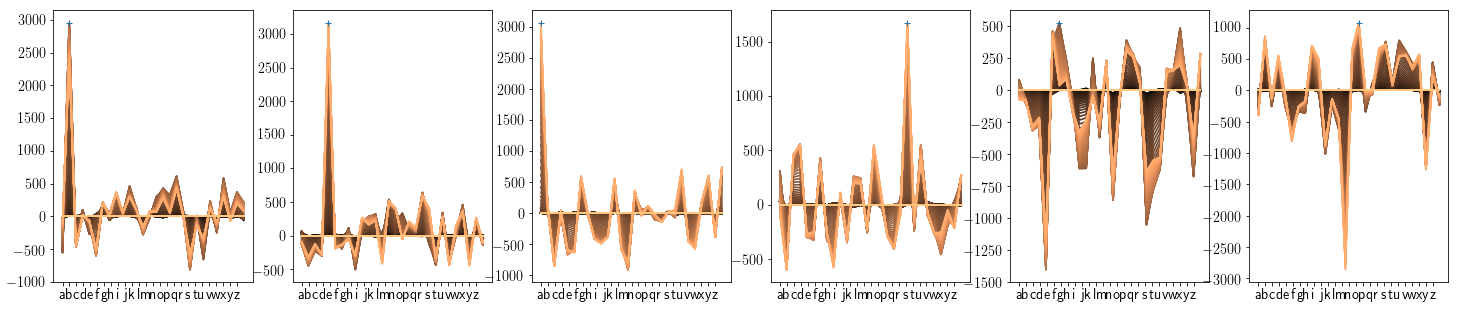

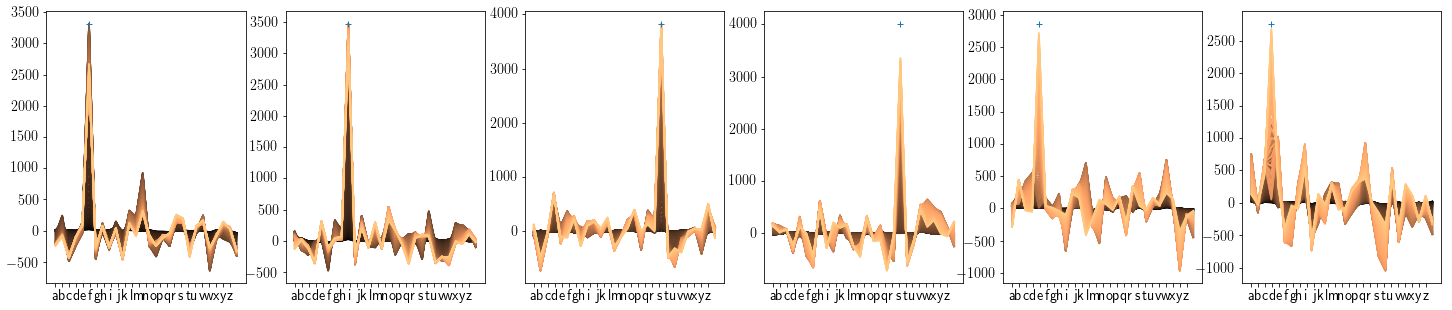

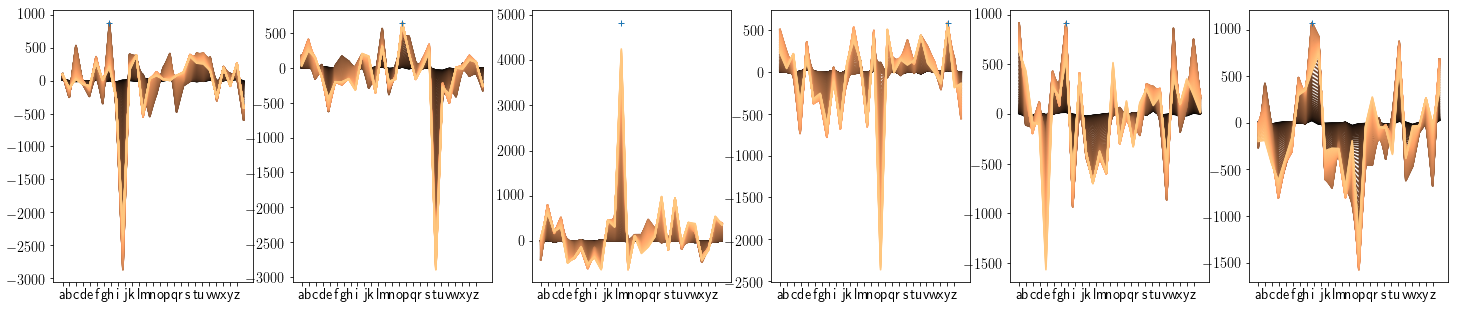

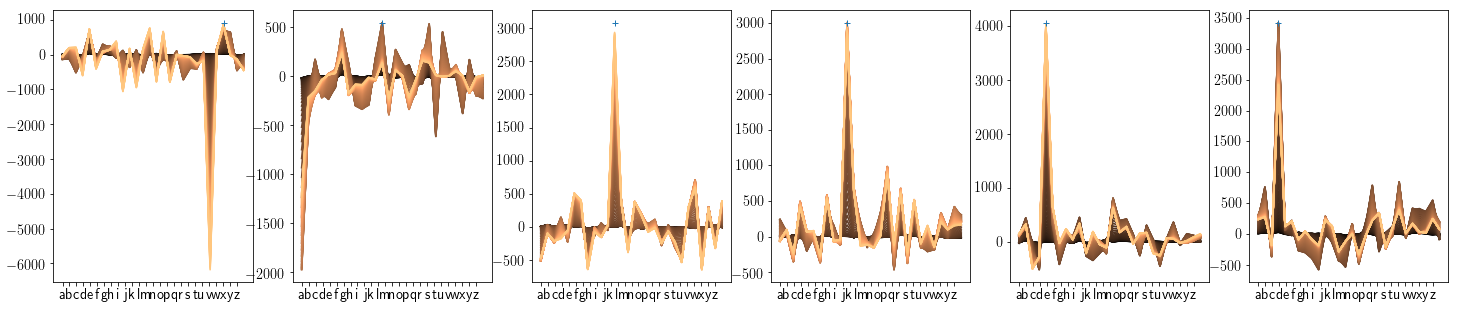

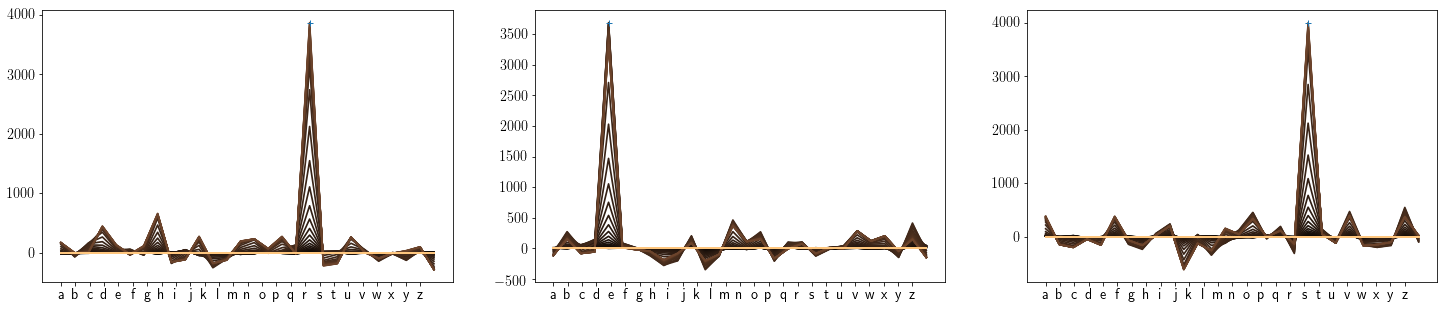

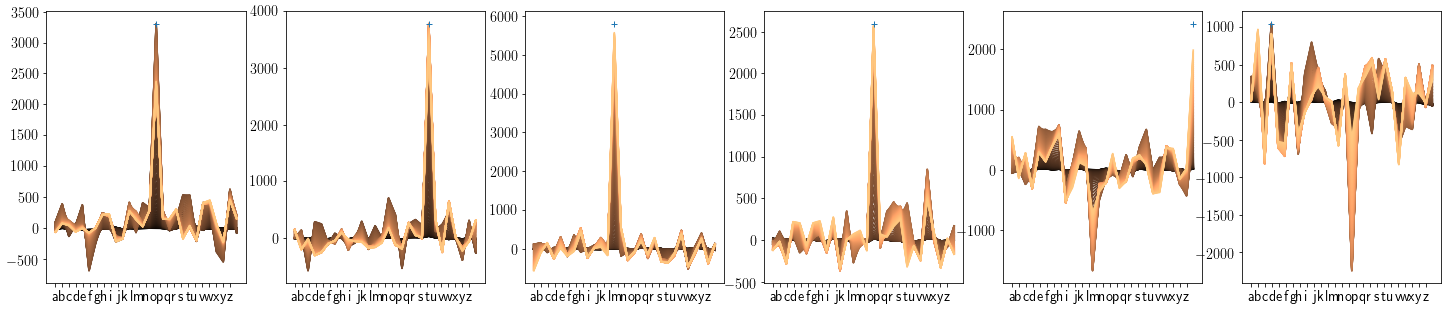

In [7]:
nsteps = 500
n_steps = 100
atol = 0.034
rtol = 0.264

# train set
for i in range(len(verbs)):
    past, pres = verbs[i][0], verbs[i][1]
    word_length = len(past)
    pred_vec = pres1[i] * bound_vec + pres2[i]
    
    states, coef_hists = state_setup(word_length+2, dic2, N, D, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        pred_vec, states, coef_hists, word_length+2, dic2, 
        N, D, atol, rtol, nsteps)
    print (all_converged, steps)
#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred, alphis = spell(coef_hists)
    print ('alphis', alphis)
    print (pred, past)

    resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)

for i in range(len(testverbs)):
    past, pres = testverbs[i][0], testverbs[i][1]
    word_length = len(past)
    pred_vec = testpres1[i] * bound_vec + testpres2[i]
    
    states, coef_hists = state_setup(word_length+2, dic2, N, D, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        pred_vec, states, coef_hists, word_length+2, dic2, 
        N, D, atol, rtol, nsteps)
    print (all_converged, steps)
#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred, alphis = spell(coef_hists)
    print ('alphis', alphis)
    print (pred, past)

    resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)

In [154]:
atols = []
rtols = []

N = 5000
word_length = 5
nsteps = 100

for i in range(8,100):
    for j in range(1,100):
#         print ('i,j', i, j)
        atol = i*.0005
        rtol = j*.0005
        
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        
        word_vec = ngram_encode_cl(word[:word_length], dic1, alph)
        states, coef_hists = state_setup(word_length+2, dic1, N, D, nsteps)

        states, coef_hists, all_converged, steps = explain_away(word_vec, states, coef_hists, word_length+2, dic1, N, D, atol, rtol, nsteps)
        pred, alphis = spell(coef_hists)
        actual = word[:word_length]
        if pred == actual and np.all(all_converged) and steps < nsteps-1:
            print ('atol', atol)
            print ('rtol', rtol)
            print (pred, actual, all_converged, steps)
            atols.append(atol)
            rtols.append(rtol)

('atol', 0.004)
('rtol', 0.019)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 81)
('atol', 0.004)
('rtol', 0.033)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 76)
('atol', 0.004)
('rtol', 0.039)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 90)
('atol', 0.004)
('rtol', 0.041)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 84)
('atol', 0.004)
('rtol', 0.043500000000000004)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 86)
('atol', 0.0045000000000000005)
('rtol', 0.042)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 95)
('atol', 0.0045000000000000005)
('rtol', 0.0445)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 86)
('atol', 0.0045000000000000005)
('rtol', 0.0495)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 86)
('atol', 0.005)
('rtol', 0.017)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 91)
('atol', 0.005)
('rtol', 0.0315)
('pneum', 'pneum', array([ 1.,  1.,  1.,  1.,  1.]), 97)


KeyboardInterrupt: 